In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [122]:
# This method is to read the file from Gdrive since dataset is too big to upload to Github
# https://drive.google.com/file/d/1IkbrtT3QZaWZCbgjNL6JbReId-34uB5X/view?usp=drive_link
file_id = '1IkbrtT3QZaWZCbgjNL6JbReId-34uB5X'
url = f'https://drive.google.com/uc?id={file_id}'

# Load CSV
df = pd.read_csv(url)
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (225745, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [123]:
# Check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values:\n", missing)

Missing values:
 Flow Bytes/s    4
dtype: int64


In [124]:
# Check datatypes and general info
print("\nData types and non-null counts:")
df.info()


Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet

In [125]:
# Strip whitespace from all column names
df.columns = df.columns.str.strip()

In [126]:
# Check the value counts of the target
print("\nLabel Distribution:")
print(df['Label'].value_counts())


Label Distribution:
Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64


In [127]:
# Replace 'Infinity' and other string issues with actual np.nan
df.replace(['Infinity', 'NaN', 'nan', 'NaN ', ' NAN'], np.nan, inplace=True)

# Drop columns with all NaNs or a single unique value
df.dropna(axis=1, how='all', inplace=True)
for col in df.columns:
    if df[col].nunique() <= 1:
        df.drop(columns=col, inplace=True)

# Check again
print("Cleaned shape:", df.shape)
print("Remaining columns:\n", df.columns.tolist()[:10])

Cleaned shape: (225745, 69)
Remaining columns:
 ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']


In [128]:
print("Still missing:\n", df.isnull().sum().sort_values(ascending=False).head(10))

Still missing:
 Flow Bytes/s            4
Destination Port        0
Subflow Fwd Packets     0
Avg Bwd Segment Size    0
Avg Fwd Segment Size    0
Average Packet Size     0
Down/Up Ratio           0
ECE Flag Count          0
URG Flag Count          0
ACK Flag Count          0
dtype: int64


In [129]:
# Drop rows with any missing values
df.dropna(inplace=True)

# Confirm it's clean now
print("After drop, shape:", df.shape)
print("Missing values left:\n", df.isnull().sum().sum())

After drop, shape: (225741, 69)
Missing values left:
 0


In [130]:
print("Still missing:\n", df.isnull().sum().sort_values(ascending=False).head(10))

Still missing:
 Destination Port        0
ACK Flag Count          0
Avg Bwd Segment Size    0
Avg Fwd Segment Size    0
Average Packet Size     0
Down/Up Ratio           0
ECE Flag Count          0
URG Flag Count          0
PSH Flag Count          0
Min Packet Length       0
dtype: int64


In [131]:
# Create a binary label: 0 = BENIGN, 1 = attack
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# Confirm the distribution
print(df['Label'].value_counts())

Label
1    128027
0     97714
Name: count, dtype: int64


In [132]:
# Separate features and target
X = df.drop('Label', axis=1)
y = df['Label']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (225741, 68)
y shape: (225741,)


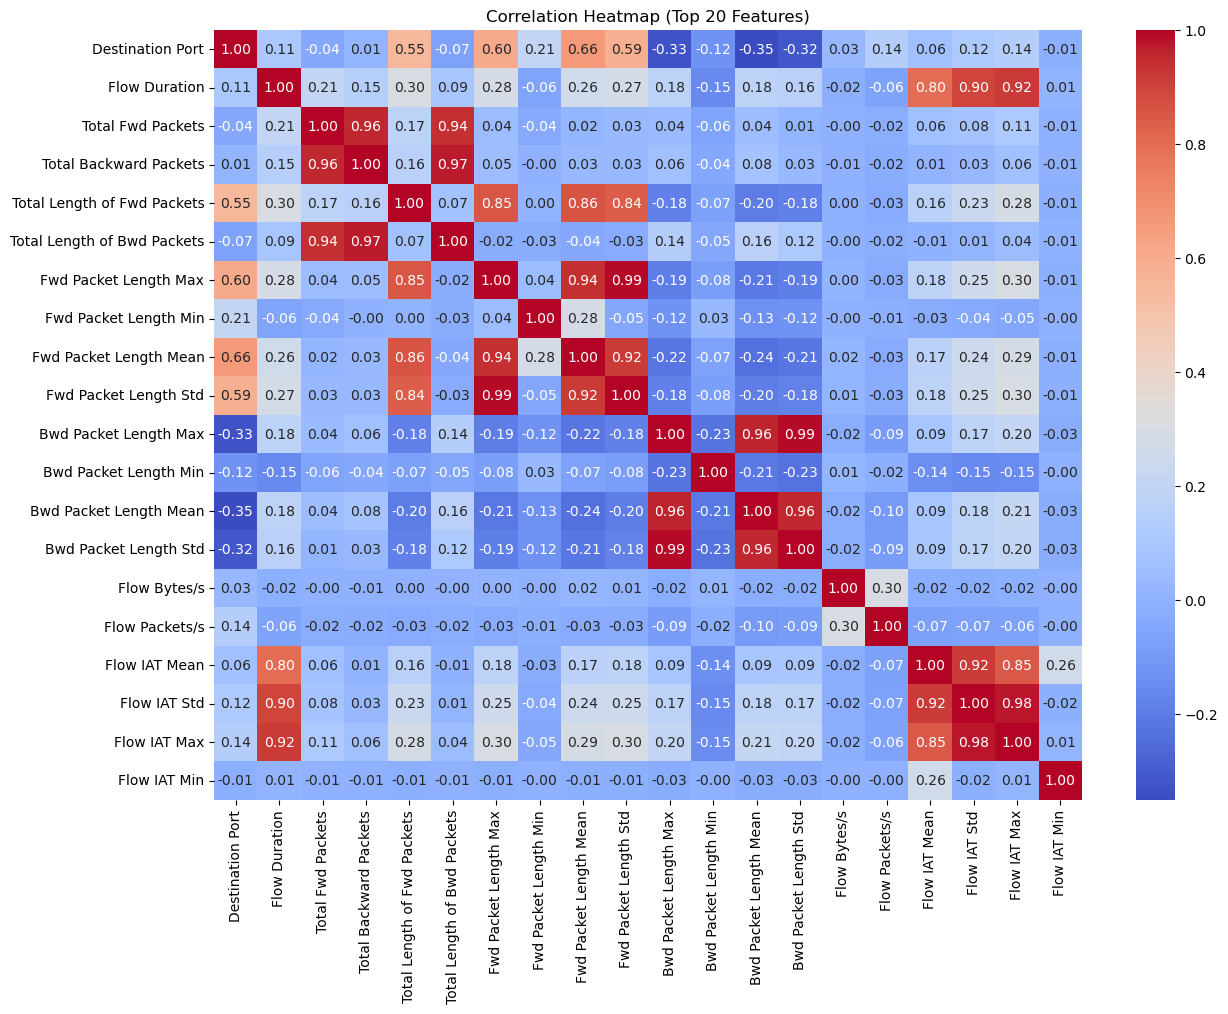

In [133]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Plot heatmap (we’ll focus on top 20 to keep it readable)
plt.figure(figsize=(14, 10))
sns.heatmap(corr.iloc[:20, :20], annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap (Top 20 Features)")
plt.show()

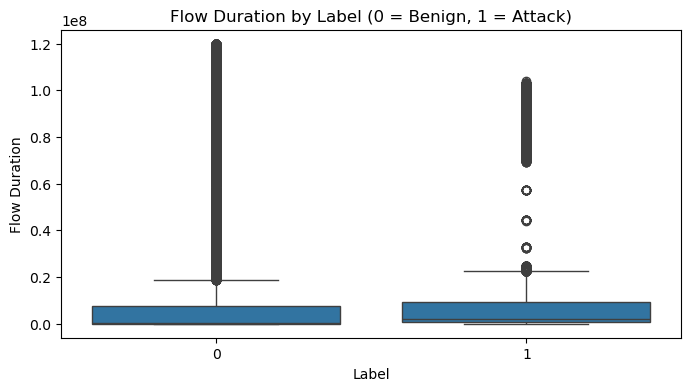

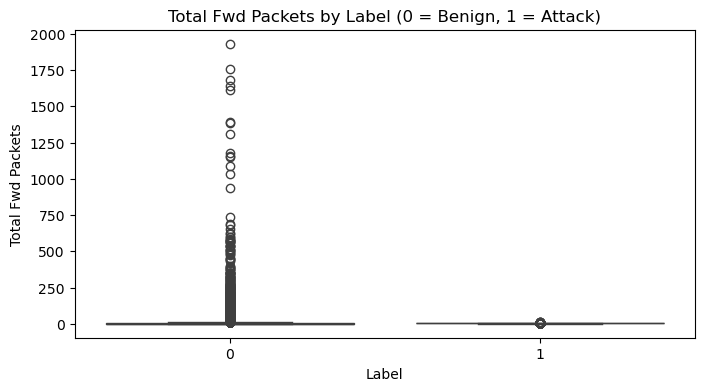

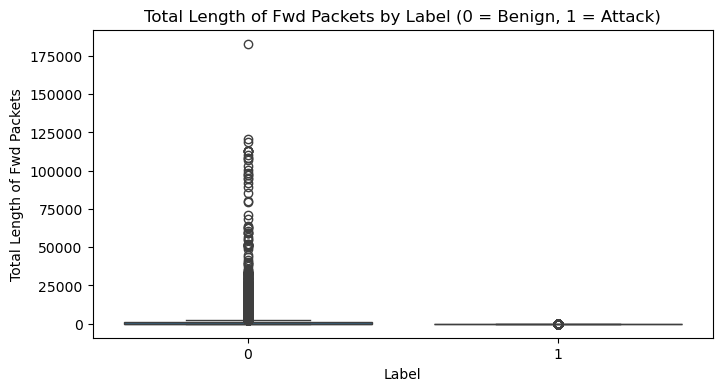

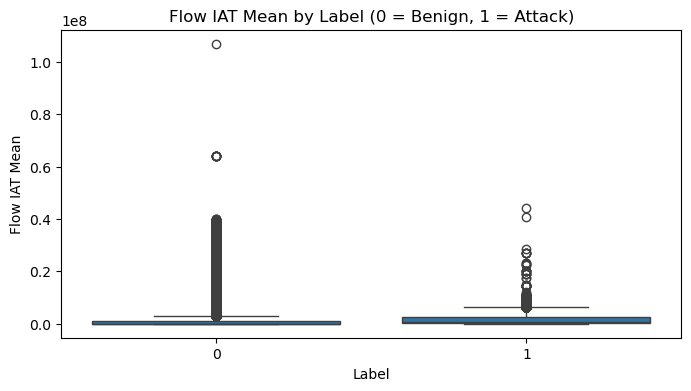

In [134]:
features_to_plot = ['Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Flow IAT Mean']

# Boxplots for each feature vs label
for col in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='Label', y=col)
    plt.title(f'{col} by Label (0 = Benign, 1 = Attack)')
    plt.show()

In [135]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [136]:
# Find max values for each column since I am getting error when scaling.
max_vals = X.max()
print(max_vals.sort_values(ascending=False).head(10))

Flow Bytes/s              inf
Flow Packets/s            inf
Bwd IAT Min       120000000.0
Bwd IAT Mean      120000000.0
Bwd IAT Total     120000000.0
Fwd IAT Min       120000000.0
Fwd IAT Max       120000000.0
Fwd IAT Mean      120000000.0
Fwd IAT Total     120000000.0
Flow IAT Max      120000000.0
dtype: float64


In [137]:
# Drop problematic columns
cols_to_drop = ['Flow Bytes/s', 'Bwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Total',
                'Fwd IAT Min', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Total',
                'Flow IAT Max', 'Idle Min']
X.drop(columns=cols_to_drop, inplace=True)

In [138]:
# Replace +inf and -inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows that have any NaN
X = X.dropna()

# Sync y with cleaned X (just in case)
y = y.loc[X.index]

# Sanity check
print("Any NaNs?", X.isnull().values.any())
print("Any +inf?", np.isinf(X.values).any())
print("X shape:", X.shape)

Any NaNs? False
Any +inf? False
X shape: (225711, 58)


In [139]:
# Re-split after dropping columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [140]:
# Train logistic regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [141]:
#Grid Search for Logistic Regression

from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, scoring='f1', cv=5)
grid_lr.fit(X_train_scaled, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Best F1 Score (CV):", grid_lr.best_score_)

Best Logistic Regression Params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 Score (CV): 0.9989592202237644


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19419
           1       1.00      1.00      1.00     25724

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



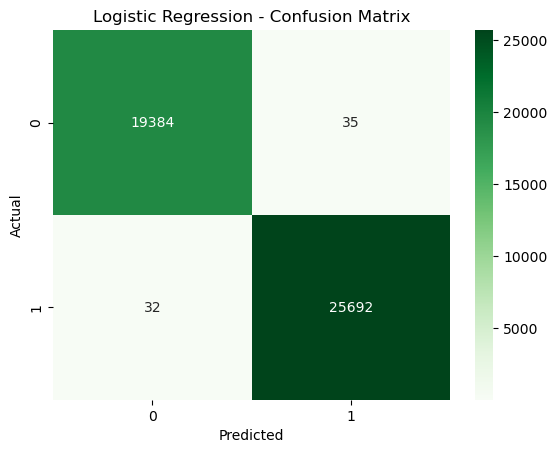

Logistic Regression - ROC AUC Score: 0.9998


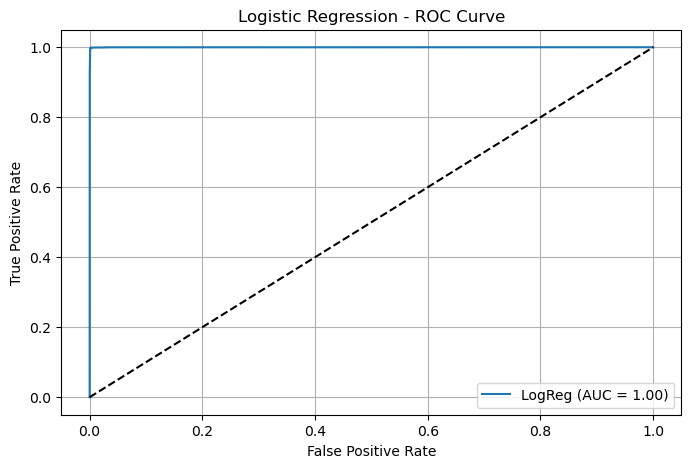

In [142]:
# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print("Logistic Regression - ROC AUC Score:", round(roc_auc_lr, 4))

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(8, 5))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Random forest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))

In [ ]:
#Isolation forest

from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(X_train)
y_pred_iso = iso.predict(X_test)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]  # Convert to anomaly = 1

# Evaluate
print("Isolation Forest Classification Report:")
print(classification_report(y_test, y_pred_iso))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_iso))

In [ ]:
#Autoencoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build Autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(encoded)
output_layer = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True,
                validation_split=0.1, verbose=1)

# Reconstruction error
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
threshold = np.percentile(mse, 90)  # Top 10% as anomalies
y_pred_auto = [1 if e > threshold else 0 for e in mse]

# Evaluate
print("Autoencoder Classification Report:")
print(classification_report(y_test, y_pred_auto))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_auto))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def summarize_model(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_pred)
    }

results = [
    summarize_model("Logistic Regression", y_test, y_pred_lr),
    summarize_model("Random Forest", y_test, y_pred_rf),
    summarize_model("Isolation Forest", y_test, y_pred_iso),
    summarize_model("Autoencoder", y_test, y_pred_auto)
]

import pandas as pd
comparison_df = pd.DataFrame(results)
print("📊 Extended Model Comparison Table:")
print(comparison_df)

In [ ]:
#Confusion metrics for each model:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels
labels = ["Benign", "Anomaly"]

# Function to plot confusion matrix
def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

plot_cm(y_test, y_pred_lr, "Logistic Regression", axs[0, 0])
plot_cm(y_test, y_pred_rf, "Random Forest", axs[0, 1])
plot_cm(y_test, y_pred_iso, "Isolation Forest", axs[1, 0])
plot_cm(y_test, y_pred_auto, "Autoencoder", axs[1, 1])

plt.tight_layout()
plt.show()